# Introduction 

This workbook demonstrates the code for the paper **Fast estimation of sparse quantum noise** by *Harper, Yu and Flammia* (in production).


## Scalable Estimation

This is the main workbook which uses data taken from the IBM Quantum Experience (Melbourne device, when it only had 14 qubits), uses that to create a full Pauli distribution and then attempts to reconstruct the distribution from limited sampling of the eigenvalues corrupted by varying levels of noise. It contains the code, analysis and figures that appear in the paper. It does, however, assume a certain level of knowledge which is the point of the workbooks also contained in this repository

It implicilty uses the algorithm detailed in **Efficient Learning of quantum Noise** [arXiv:1907.13022](https://arxiv.org/abs/1907.13022) , code for which is located at https://github.com/rharper2/Juqst.jl. Python code to run such experiments on the IBM Quantum Experience (using qiskit) can be found on https://github.com/rharper2/query_ibmq.

Copyright: Robin Harper 2019-2020

## Note re code

We are going to need some more of my code to reconstruct a test probability distribution.

You can get it by doing the following, in the main julia repl (hit ']' to get to the package manager)

```
pkg> add https://github.com/rharper2/Juqst.jl
```

Currently there is harmless warning re overloading Hadamard.


In [1]:
using LsqFit
using Hadamard
using PyPlot
using Juqst
# convenience (type /otimes<tab>)
⊗ = kron
# /oplus tab
⊕ = (x,y)->mod.(x+y,2)
savePics = false


false

In [2]:
include("./peel.jl")


Main.PEEL

In [3]:
# We use all the following, mainly to get pretty pictures

using ProgressMeter
using Main.PEEL
using Distributions
using Pandas
using Seaborn
using PyCall

In [4]:
# Read in the raw results stored on a per sequence length
# Binary valued so first entry = 0000000000000000
# Then a 1 on qubit 0 is the second entry i.e. 0000000000000001
# all the way to a 1 on all qubits 111111111111111111111111
using DelimitedFiles
# Read in the raw csv
fullMatrixS = readdlm("./data/results14Single_1_5_10_15_20_30_45_60_75_90_105.csv",',',Int64);
# Change into a list of matrices, turned into probabilities
splitMatrixS=[fullMatrixS[i,:]/sum(fullMatrixS[i,:]) for i in 1:11];
# From the experiment
singleLengths=vcat([1,5,10,15,20],collect(30:15:110));
# Fit each of the numbers (after Hadamard transform)
params, dataL  = fitTheFidelities(singleLengths,splitMatrixS);
# Use the fit parameters to construct the fidelities, transform back and project.
singleParams = copy(params);
estimatedF = vcat([1],map(x->x[2],singleParams));
singlePs =  fwht_natural(estimatedF)
singlePps = projectSimplex(singlePs);

In [5]:
singlePps

16384-element Array{Float64,1}:
 0.8957596288754209
 0.0024871295493229897
 0.018047404612613883
 0.00030423453669673584
 0.009712507265113725
 6.643961624550098e-5
 0.00022288840055383134
 0.0
 0.003855545990655799
 4.801199988861579e-5
 0.0
 0.0
 5.663832632332087e-5
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [6]:
# Use the clifford twirl to generate a fake Pauli twirl
# Here Paulis are 2 bit numbers (i.e. think of as base 4 expressed in binary)
# Think of it as 00 -> I 01 -> X 10 -> Y and 11 -> Z where we talk about eigenval|ues
# And 00->I 10->X 01->Y 11->Z when we are talking probability vector
# See the workbook title "Scalable Estimation - Basic concepts" for a full explanation.

p28 = generatePauliFromClifford(singlePps)
oracle28 = ifwht_natural(p28);

In [7]:
# Create the 'bit' offsets
ds = vcat(
    [[0 for _ = 1:28]],
    [map(x->parse(Int,x),collect(reverse(string(i,base=2,pad=28)))) for i in [2^b for b=0:27]]);
# e.g.
ds[1:6,:]

6×1 Array{Array{Int64,1},2}:
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [8]:
paulisAll = []

mappings=[]

 
potentialSingles = [
                    [[0,0],[0,1]], # IX
                    [[0,0],[1,0]], # IY
                    [[0,0],[1,1]], # IZ
                    ]


all2QlMuBs =  [  [[0,0,0,0],[1,1,0,1],[1,0,1,1],[0,1,1,0]], #II ZX YZ XY
                 [[0,0,0,0],[1,1,1,0],[0,1,1,1],[1,0,0,1]], #II ZY XZ YX
                 [[0,0,0,0],[0,0,0,1],[0,1,0,0],[0,1,0,1]], #II IX XI XX
                 [[0,0,0,0],[0,0,1,0],[1,0,0,0],[1,0,1,0]], #II IY YI YY
                 [[0,0,0,0],[0,0,1,1],[1,1,0,0],[1,1,1,1]]] #II IZ ZI ZZ

# We only want to choose the first two types for the initial runs
potentialMuBs = [all2QlMuBs[1],all2QlMuBs[2]]




# Create a bunch of randomly chosen two qubit mubs (7 of them) as we have 14 qubits.
for i = 1:1
     push!(mappings,Dict())
     choose = rand(1:2,7)
     push!(paulisAll,vcat([potentialMuBs[x] for x in choose]))
end



# Create random single, 6 random two, the a random single
# This 'offsets' the two qubit Mubs by one qubit - which appears to be great for splitting things up.
for i = 1:1
     push!(mappings,Dict())
     chooseS = rand(1:3,2)
     choose = rand(1:2,6)
     push!(paulisAll,vcat([potentialSingles[chooseS[1]]],[potentialMuBs[x] for x in choose],[potentialSingles[chooseS[2]]]))
end




In [9]:
paulisAll[1]

7-element Array{Array{Array{Int64,1},1},1}:
 [[0, 0, 0, 0], [1, 1, 0, 1], [1, 0, 1, 1], [0, 1, 1, 0]]
 [[0, 0, 0, 0], [1, 1, 1, 0], [0, 1, 1, 1], [1, 0, 0, 1]]
 [[0, 0, 0, 0], [1, 1, 1, 0], [0, 1, 1, 1], [1, 0, 0, 1]]
 [[0, 0, 0, 0], [1, 1, 0, 1], [1, 0, 1, 1], [0, 1, 1, 0]]
 [[0, 0, 0, 0], [1, 1, 0, 1], [1, 0, 1, 1], [0, 1, 1, 0]]
 [[0, 0, 0, 0], [1, 1, 0, 1], [1, 0, 1, 1], [0, 1, 1, 0]]
 [[0, 0, 0, 0], [1, 1, 0, 1], [1, 0, 1, 1], [0, 1, 1, 0]]

In [10]:
paulisAll[2]

8-element Array{Array{Array{Int64,1},1},1}:
 [[0, 0], [1, 0]]
 [[0, 0, 0, 0], [1, 1, 0, 1], [1, 0, 1, 1], [0, 1, 1, 0]]
 [[0, 0, 0, 0], [1, 1, 0, 1], [1, 0, 1, 1], [0, 1, 1, 0]]
 [[0, 0, 0, 0], [1, 1, 0, 1], [1, 0, 1, 1], [0, 1, 1, 0]]
 [[0, 0, 0, 0], [1, 1, 0, 1], [1, 0, 1, 1], [0, 1, 1, 0]]
 [[0, 0, 0, 0], [1, 1, 1, 0], [0, 1, 1, 1], [1, 0, 0, 1]]
 [[0, 0, 0, 0], [1, 1, 0, 1], [1, 0, 1, 1], [0, 1, 1, 0]]
 [[0, 0], [1, 1]]

In [11]:
# Create a noise oracle

function getNoisyOracle(sigma;oracle = oracle28)
    F2 = copy(oracle)
    F2 += rand(Normal(0,sigma),length(F2))
    # Note we are not assuming that we can do anything with this oracle - i.e. might be too large to write down
    # Otherwise we could transform, project and transform back
    return F2
end


getNoisyOracle (generic function with 1 method)

In [12]:
"""
The main reconstruction function used to gather statistics.

Call this with a noise and the "oracle" it will add noise are return the reconstructed distribution.

Noise = variance of noise to be added to the oracle
PaulisAll gives it the mubs we need
DS the list of bit offsets to use.
Params gives it the values needed for noisy zero bin and singleton dectection.
If the function stalls, i.e. can't recover any further paulis it will 
Loosen the bounds i.e. less likely to declare a noisy bucket as only with zeros
And more likely to find that there is only one noisy pauli in a particular bucket.
The increment to the singleton detection and decrease of zeroton detection is passed in through params
It returns if after a pass the recovered probabilities are > cutoff (default 1)

Finally the reconstruction might fail depending on the parameters passed in. We can detect this because the
total probabilities recovered, won't be close to 1. If this is the case, we naively try a few times but
increase the frequency with which we accept singletons (singletonIncrease parameter) - but there could be 
all sorts of other reasons. The parameters we use in this worksheet are trying to 'overachieve' 
i.e. recover even more than our proofs indicate are possible, effectively we can limit this and recover
what we can recover. The point here is we know that the reconstruction failed for a certain parameter set, 
but it should be possible to still effectively reconstruct the noise with a different one --- and we will
know when we have.

Just now the we don't really try very hard if we fail, just play with the singletonincrease value.
All such attempts are logged in reconstructionLog.txt - if we fail to recover then the oracle that caused 
us to fail is also saved - mainly for debugging etc purposes.
"""
function reconstructWithNoise(noise,paulisAll,mappings,ds,paramsSupplied;verbose=false,oracleToUse=oracle28,passTest=noise)
    paramsToUse = copy(paramsSupplied)
    F2 = getNoisyOracle(noise,oracle=oracleToUse)
    found = doPeel(F2,paulisAll,mappings,ds,paramsToUse,verbose=verbose)
    raqExtracted = zeros(Float64,2^28,1);
    for vv in keys(found)
      i = parse(Int,vv,base=2) 
      raqExtracted[i+1]=mean(found[vv])
    end
    count = 0
    retry = false
    bestRaq = copy(raqExtracted)
    test = abs(sum(raqExtracted)-1)
    bestTest = test
    while test > passTest
        open("reconstructionLog.txt", "a") do io
            write(io,"$count: We got a sum of .. $(sum(raqExtracted))\n")
        end
        if (count > 20)
            open("reconstructionLog.txt", "a") do io
                write(io,"*** FAILED **** Giving up returning best so far ... $(sum(bestRaq))\n")
            end
            return bestRaq
        end
        retry = true
        open("reconstructionLog.txt", "a") do io
            write(io,"$noise - Failed to converge with $paramsToUse\n")
        end
        paramsToUse["singletonIncrease"]=paramsToUse["singletonIncrease"]*1.1
        found = doPeel(F2,paulisAll,mappings,ds,paramsToUse,verbose=verbose)
        raqExtracted = zeros(Float64,2^28,1);
        for vv in keys(found)
          i = parse(Int,vv,base=2) 
          raqExtracted[i+1]=mean(found[vv])
        end
        ntest = abs(sum(raqExtracted)-1)
        if ntest >= test
            count +=1
        else 
            test = ntest
            bestRaq = copy(raqExtracted)
        end
    end
    if retry
        open("reconstructionLog.txt", "a") do io
            write(io,"Success detected, changing the parameters to $paramsToUse worked - $(sum(raqExtracted)).\n")
        end
    end
   return raqExtracted
end


"""
The main reconstruction function used to actually peel.

Pass in your vector of noisy eigenvalues (aka noisy Oracle), the list of Paulis etc (see below) and
it returns a dictionary of found bit values and their estimated values.

Noise = variance of noise to be added to the oracle
PaulisAll gives it the mubs we need
DS the list of bit offsets to use.
Params gives it the values needed for noisy zero bin and singleton dectection.
If the function stalls, i.e. can't recover any further paulis it will 
Loosen the bounds i.e. less likely to declare a noisy bucket as only with zeros
And more likely to find that there is only one noisy pauli in a particular bucket.
The increment to the singleton detection and decrease of zeroton detection is passed in through params
It returns if after a pass the recovered probabilities are > cutoff (default 1)
"""
function doPeel(noisyEigenvalues,paulisAll,mappings,ds,params;verbose=false)
    found = Dict()
    listOfXP = []
    for (ix,x) in enumerate(paulisAll)
        push!(listOfXP,[fwht_natural([noisyEigenvalues[x+1] for x in generateFromPVecSamples4N(x,d,mappings[ix])]) for d in ds])
    end
    listOfPs=[]
    for p in paulisAll
        hMap = []
        for i in p
           #print("Length $(length(i))\n")
           if length(i) == 2
                push!(hMap,twoPattern(i))
            elseif length(i) == 4
                push!(hMap,fourPattern([i])[1])
            else # Assume a binary bit pattern
                push!(hMap,[length(i)])
            end
        end
        push!(listOfPs,hMap)
    end
    listOfX=listOfXP
    singletons = get(params,"singletons",1e-9)
    singletonsInc = get(params,"singletonIncrease",1e-8)
    zerosC = get(params,"Zerosensitivity",1.1e-9)
    zerosDec = get(params,"ZerosensitivityDecrease",1e-11)
    cutoff = get(params,"Cutoff",1)
    rmappings = []
    for x in mappings
        if length(x) == 0
            push!(rmappings,x)
        else
            ralt = Dict()
            for i in keys(x)
                ralt[x[i]]= i
            end
            push!(rmappings,ralt)
        end
    end

    prevFound = 0
    qubitSize = 14
    
    for i = 1:500
    #print("i = $i\n")
        for co = 1:length(listOfX)
            bucketSize = length(listOfX[co][1])
            for extractValue = 1:bucketSize
                extracted = [x[extractValue] for x in listOfX[co]]
                if (verbose)
                    if extractValue == 1
                        print("$extracted\n")
                    end
                end
                if !(PEEL.closeToZero(extracted,qubitSize*2,cutoff=zerosC))
                    (isit,bits,val) = PEEL.checkAndExtractSingleton([extracted],qubitSize*2,cutoff=singletons)
                    if isit
                        vval = parse(Int,bits,base=2)
                        PEEL.peelBack(listOfX,listOfPs,bits,val,found,ds,rmappings)
                    end
                end
            end   
        end
        if length(found) > prevFound
                prevFound = length(found)
        else
            if verbose 
                print("*")
            end
            singletons += singletonsInc
            zerosC -=zerosDec 
            if (zerosC <= 0)
                break
            end #/=1.1#05#-= zerosDec
        end

        if length(found) > 0
            if verbose 
                print("Pass $i, $(length(found)) $(sum([mean(found[x]) for x in keys(found)]))\n")
            end
            if sum([mean(found[x]) for x in keys(found)]) >= 0.999995
                break
            end
        end
    end
    return found
end



doPeel

In [13]:
# With different levels of noise, the parameters change
# Basically the more noise we put in the more tolerant we 
# have to be of a singleton having multiple values.


params = Dict("Cutoff"=>0.999995,"singletons"=>1e-10,
                "singletonIncrease"=>2e-10,
                "Zerosensitivity"=>5.1e-9,
                "ZerosensitivityDecrease"=>1e-11)


# Works well with  0.005 noise
params1 = Dict("Cutoff"=>0.999995,"singletons"=>1e-8,
                "singletonIncrease"=>2e-8,
                "Zerosensitivity"=>1.1e-8,
                "ZerosensitivityDecrease"=>1e-10)

# Works well with 0.01 noise
params2 = Dict("Cutoff"=>0.999995,"singletons"=>2e-8,
                "singletonIncrease"=>1e-8,
                "Zerosensitivity"=>5.1e-8,
                "ZerosensitivityDecrease"=>2e-10)






Dict{String,Float64} with 5 entries:
  "singletons"              => 2.0e-8
  "Zerosensitivity"         => 5.1e-8
  "Cutoff"                  => 0.999995
  "singletonIncrease"       => 1.0e-8
  "ZerosensitivityDecrease" => 2.0e-10

In [14]:
# We use it like this, where raqExtracted is our recovered probability distribution
raqExtracted = reconstructWithNoise(0.01,paulisAll,mappings,ds,params2);

sum(raqExtracted)

1.0003349127849903

In [15]:
# And if we want to checkout the Jensen Shanon Distance then this
sqrt(JSD(p28,raqExtracted))

0.07817193021254615

In [16]:
# And of course the one norm
using LinearAlgebra
0.5*norm(p28-raqExtracted,1)

0.008353939974249996

In [17]:
# Lets gather some statistics 
# This takes some time.

# Saved as LocalMuBstats.csv 
reps = 200
gathered = []
@showprogress for i = 1:reps
    raqExtracted = reconstructWithNoise(0.01,paulisAll,mappings,ds,params2);
    x = JSD(p28,raqExtracted)
    #print("$i - $x $(sum(raqExtracted))\n")
    push!(gathered,(x,0.5*norm(p28-raqExtracted,1),sum(raqExtracted)))
end

gathered2 = []
@showprogress for i = 1:reps
    raqExtracted = reconstructWithNoise(0.005,paulisAll,mappings,ds,params1,passTest = 0.001);
    x = JSD(p28,raqExtracted)
    #print("$i - $x $(sum(raqExtracted))\n")
    push!(gathered2,(x,0.5*norm(p28-raqExtracted,1),sum(raqExtracted)))
end
        

gathered3 = []
# A slightly higher passTest here than default to get a good reconstruction.
@showprogress for i = 1:reps
    raqExtracted = reconstructWithNoise(0.001,paulisAll,mappings,ds,params);
    x = JSD(p28,raqExtracted)
    #print("$i - $x $(sum(raqExtracted))\n")
    push!(gathered3,(x,0.5*norm(p28-raqExtracted,1),sum(raqExtracted)))
end



Progress: 100%|█████████████████████████████████████████| Time: 1:15:55
Progress: 100%|█████████████████████████████████████████| Time: 0:58:40
Progress: 100%|█████████████████████████████████████████| Time: 1:28:01


In [18]:
filter(x->sqrt(x[1])>0.09,gathered3)

0-element Array{Any,1}

In [19]:
open("localMuBstats.csv", "w") do f
    write(f,"JSD,Norm,σ\n")
    for i = 1:reps
        write(f, "$(gathered[i][1]), $(gathered[i][2]), 0.01\n")
        write(f, "$(gathered2[i][1]), $(gathered2[i][2]), 0.005\n")
        write(f, "$(gathered3[i][1]), $(gathered3[i][2]), 0.001\n")
    end
end
open("localMuBstats_sq.csv", "w") do f
    write(f,"JSD,Norm,σ\n")
    for i = 1:reps
        write(f, "$(sqrt(gathered[i][1])), $(gathered[i][2]), 0.01\n")
        write(f, "$(sqrt(gathered2[i][1])), $(gathered2[i][2]), 0.005\n")
        write(f, "$(sqrt(gathered3[i][1])), $(gathered3[i][2]), 0.001\n")
    end
end

In [20]:
using Pandas
df = read_csv("./localMuBstats_sq.csv"); 

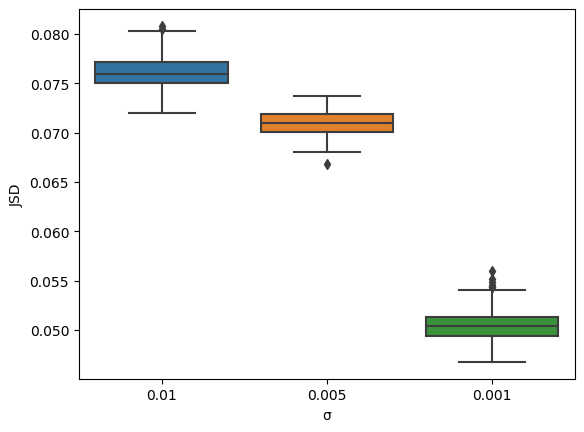

PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7ff44d6e1590>

In [21]:
using Seaborn
b=Seaborn.boxplot(x="σ",y="JSD",data=df,order=[0.01,0.005,0.001])

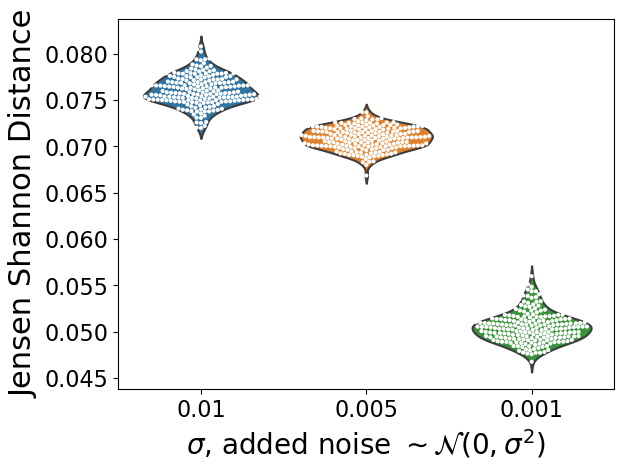

In [22]:
ax = violinplot(x="σ",y="JSD",data=df,order=[0.01,0.005,0.001],inner=nothing)
ax = swarmplot(x="σ",y="JSD",data=df,order=[0.01,0.005,0.001],
                    color="white", edgecolor="gray",size=3)
ylabel("Jensen Shannon Distance",fontsize=22)
xlabel(L"$σ$, added noise $\sim\mathcal{N}(0,\sigma^2)$",fontsize=20)
ax.tick_params(labelsize=16)

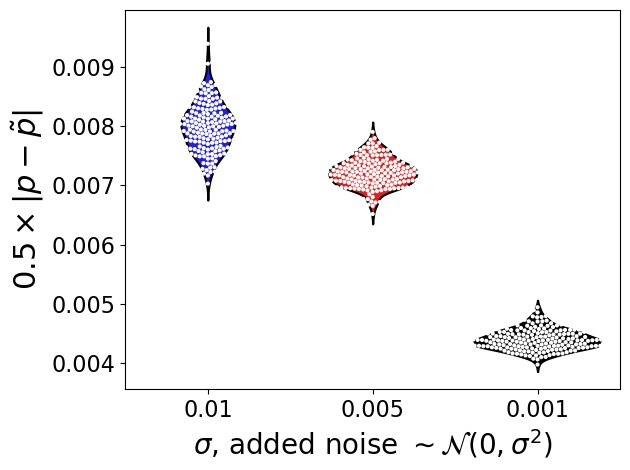

In [23]:
my_pal = Dict(0.01=> "b", 0.005=> "r", 0.001=>"k")
ax = violinplot(x="σ",y="Norm",data=df,order=[0.01,0.005,0.001],inner=nothing,palette=my_pal)
ax = swarmplot(x="σ",y="Norm",data=df,order=[0.01,0.005,0.001],
                    color="white", edgecolor="gray",size=3)
ylabel(L"$0.5\times|p-\tilde{p}|$",fontsize=22)
xlabel(L"$σ$, added noise $\sim\mathcal{N}(0,\sigma^2)$",fontsize=20)
ax.tick_params(labelsize=16)
plt.tight_layout()
if savePics == true
    savefig("ViolinPlotLocalMUBNormv2.pdf")
end

# An alternative check that this works

- Take our original distribution
- Make it 'Pauli'
- Mix it with a Clifford!

Try that.

In [24]:
using Random
function genNewOracle(singlePps)
    p28 = generatePauliFromClifford(singlePps)
    shuffle!(p28[2:end])
    oracle28 = ifwht_natural(p28);
    return oracle28
end

genNewOracle (generic function with 1 method)

In [25]:
# We can test it this other way - but it takes about 2-3 hours per run, so commented out just now.

reps = 100
gatheredRO = []
@showprogress for i = 1:reps
    no = genNewOracle(singlePps)
    np28 = projectSimplex(fwht_natural(no))
    raqExtracted = reconstructWithNoise(0.01,paulisAll,mappings,ds,params2,oracleToUse=no);
    x = JSD(np28,raqExtracted)
    #print("$i - $x $(sum(raqExtracted))\n")
    push!(gatheredRO,(x,0.5*norm(np28-raqExtracted,1)))
end

gathered2RO = []
@showprogress for i = 1:reps
    no = genNewOracle(singlePps)
    np28 = projectSimplex(fwht_natural(no))
    raqExtracted = reconstructWithNoise(0.005,paulisAll,mappings,ds,params1,oracleToUse=no);
    x = JSD(np28,raqExtracted)
    #print("$i - $x $(sum(raqExtracted))\n")
    push!(gathered2RO,(x,0.5*norm(np28-raqExtracted,1)))
end
        
gathered3RO = []
@showprogress  for i = 1:reps
    testFile = "test$i.csv"
    no = genNewOracle(singlePps)
    np28 = projectSimplex(fwht_natural(no))
    raqExtracted = reconstructWithNoise(0.001,paulisAll,mappings,ds,params,oracleToUse=no,passTest=0.0003);
    x = JSD(np28,raqExtracted)
    #print("$i - $x $(sum(raqExtracted))\n")
    push!(gathered3RO,(x,0.5*norm(np28-raqExtracted,1),sum(raqExtracted)))
end




Progress: 100%|█████████████████████████████████████████| Time: 1:46:45
Progress: 100%|█████████████████████████████████████████| Time: 1:43:17
Progress: 100%|█████████████████████████████████████████| Time: 6:45:46


In [26]:
#Save the information.
reps=100
open("localMuBstats2.csv", "w") do f
    write(f,"JSD,Norm,σ\n")
    for i = 1:reps
        write(f, "$(gatheredRO[i][1]), $(gathered[i][2]), 0.01\n")
        write(f, "$(gathered2RO[i][1]), $(gathered2[i][2]), 0.005\n")
        write(f, "$(gathered3RO[i][1]), $(gathered3[i][2]), 0.001\n")
    end
end
open("localMuBstats_sq2.csv", "w") do f
    write(f,"JSD,Norm,σ\n")
    for i = 1:reps
        write(f, "$(sqrt(gatheredRO[i][1])), $(gathered[i][2]), 0.01\n")
        write(f, "$(sqrt(gathered2RO[i][1])), $(gathered2[i][2]), 0.005\n")
        write(f, "$(sqrt(gathered3RO[i][1])), $(gathered3[i][2]), 0.001\n")
    end
end

In [27]:
# Unless you uncommented the boxes above this is a presaved one.
# There will sometimes be outliers that weren't reconstructed using the parameters given
# But you will be notified.
using Pandas
df = read_csv("./localMuBstats_sq2.csv");

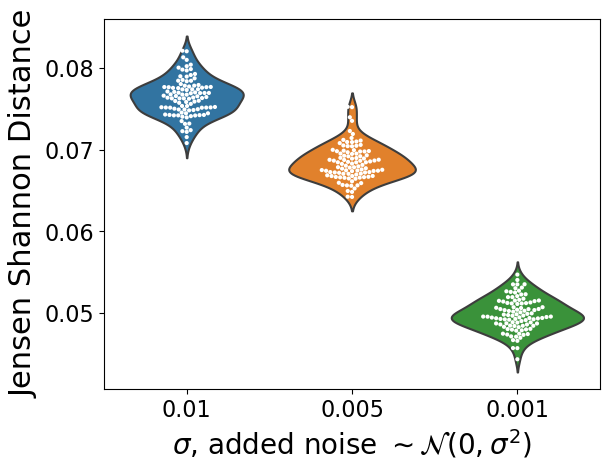

In [28]:
ax = violinplot(x="σ",y="JSD",data=df,order=[0.01,0.005,0.001],inner=nothing)
ax = swarmplot(x="σ",y="JSD",data=df,order=[0.01,0.005,0.001],
                    color="white", edgecolor="gray",size=3)
ylabel("Jensen Shannon Distance",fontsize=22)
xlabel(L"$σ$, added noise $\sim\mathcal{N}(0,\sigma^2)$",fontsize=20)
ax.tick_params(labelsize=16)

In [29]:
using PyCall
sb=pyimport("seaborn")

function plotIt(ep,sig;h=false,v=false,t=false)
    Seaborn.scatter(1:length(sfe),vec([x[2] for x in sfe]))
    Seaborn.scatter(1:length(ep),vec(ep),marker="x")
    sb.despine()
    yscale("log")
    ylim([0.00001,0.1])


    #sb.axes_style("darkgrid")
    yticks(fontsize="15")
    xticks(fontsize="15")
    #sb.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 108})
    if v
        ylabel("Pauli error probability",fontsize="20")
    else
        yticks([])
    end
    if h
        xlabel("Paulis ordered by error probability",fontsize="26")
    end
    if t
        title("Noise added: σ=$sig",fontsize="20")
    end
   ## ax= gca().add_axes([0.72, 0.72, 0.16, 0.16])
   # scatter(1:length(sfe),vec([x[2] for x in sfe]))
   # scatter(1:length(ep),vec(ep),marker="x")
    
end

plotIt (generic function with 1 method)

In [30]:
reconstructed1 = reconstructWithNoise(0.01,paulisAll,mappings,ds,params2);
reconstructed2 = reconstructWithNoise(0.005,paulisAll,mappings,ds,params1);
reconstructed3 = reconstructWithNoise(0.001,paulisAll,mappings,ds,params);


fe=filter(x->x[2]>0.0000001,collect(enumerate(p28)))
sfe = sort(fe,lt=(x,y)->x[2]>y[2])[2:end];





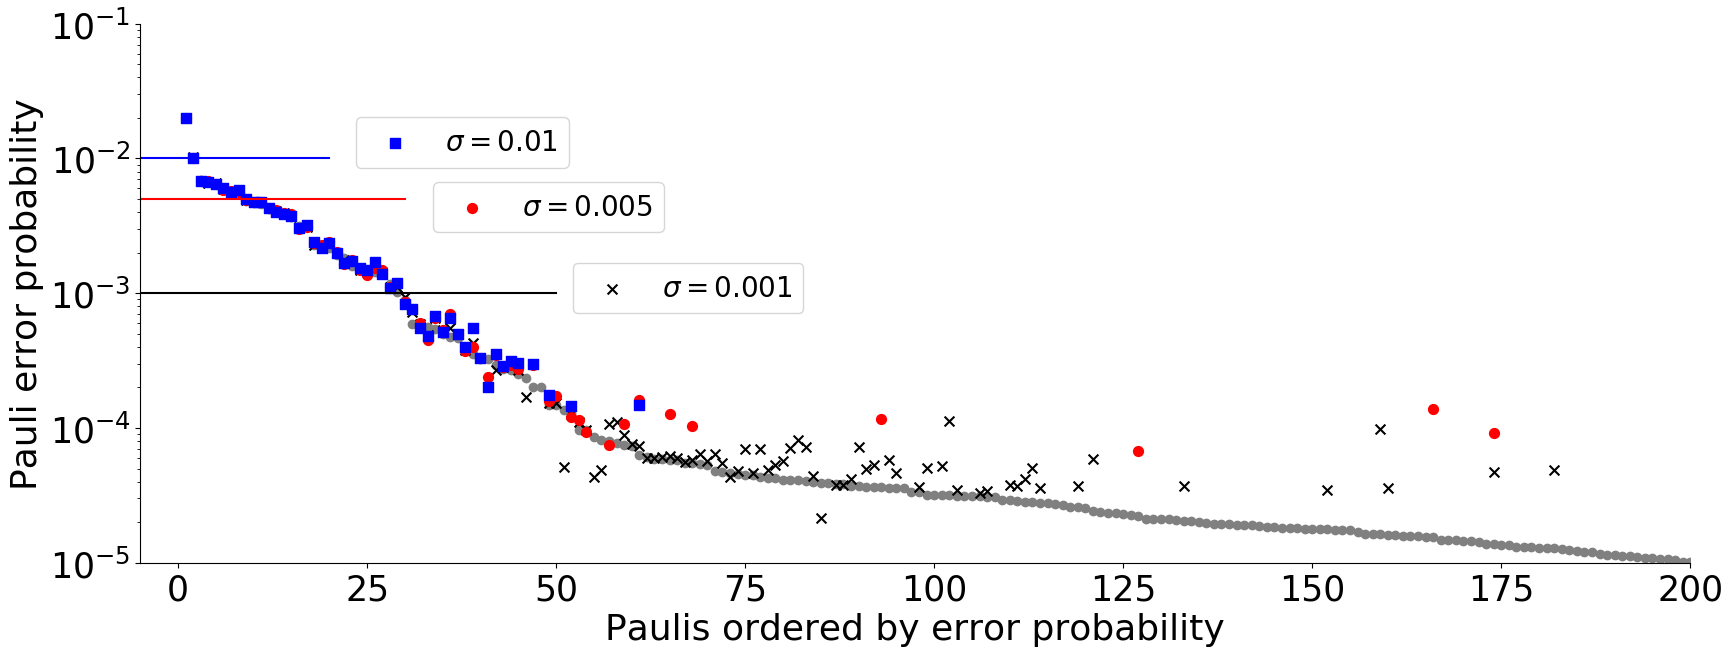

In [31]:
using Seaborn
fig = figure("Slightly larger",figsize=(20,7))
pCutoff=200
Seaborn.scatter(1:pCutoff,vec([x[2] for x in sfe[1:pCutoff]]),color="gray")
p1 = Seaborn.scatter(1:pCutoff,reconstructed3[[x[1] for x in sfe[1:pCutoff]]],marker="x",color="black",s=50,label=L"\sigma=0.001")
p2 = Seaborn.scatter(1:pCutoff,reconstructed2[[x[1] for x in sfe[1:pCutoff]]],marker="o",color="red",s=50,label=L"\sigma=0.005")
p3 = Seaborn.scatter(1:pCutoff,reconstructed1[[x[1] for x in sfe[1:pCutoff]]],marker="s",color="blue",s=50,label=L"\sigma=0.01")




Seaborn.plot([-10,20],[0.01,0.01],color="blue")
Seaborn.plot([-10,30],[0.005,0.005],color="red")
Seaborn.plot([-10,50],[0.001,0.001],color="black")




sb.despine()
yscale("log")
ylim([0.00001,0.1])
xlim([-5,200])
yticks(fontsize="25")
xticks(fontsize="25")
    #sb.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 108})
ylabel("Pauli error probability",fontsize="26")
xlabel("Paulis ordered by error probability",fontsize="26")
x1=legend(fontsize="20")
   ## ax= gca().add_axes([0.72, 0.72, 0.16, 0.16])
   # scatter(1:length(sfe),vec([x[2] for x in sfe]))
   # scatter(1:length(ep),vec(ep),marker="x")
l1 = legend([p1], [L"\sigma=0.001"],bbox_to_anchor=(0.27, 0.48, 0.1, .102), loc=2,fontsize="20")
l2 = legend([p2], [L"\sigma=0.005"],bbox_to_anchor=(0.18, 0.63, 0.1, .102), loc=2,fontsize="20") 
l3 = legend([p3], [L"\sigma=0.01"],bbox_to_anchor=(0.13, 0.75, 0.1, .102), loc=2,fontsize="20") 


gca().add_artist(l1) 
gca().add_artist(l2)

plt.show()


if savePics == true
    savefig("ReconstructionChart.pdf")
end

In [32]:
### ALTERNATIVE IF WE WANT TO EXPLORE DOUBLE TWIRL i.e. 2n^2-2n+1 experiments.
paulisN2 = []

for i = 1:1
     push!(mappings,Dict())
     choose = rand(1:2,7)
     push!(paulisN2,vcat([potentialMuBs[x] for x in choose]))
end

for i = 1:1
     push!(mappings,Dict())
     chooseS = rand(1:3,2)
     choose = rand(1:2,6)
     push!(paulisN2,vcat([potentialSingles[chooseS[1]]],[potentialMuBs[x] for x in choose],[potentialSingles[chooseS[2]]]))
end


for index in 0:6
push!(mappings,Dict())
push!(paulisN2,vcat([[[0,0,0,0],[1,0,1,1],[0,1,1,0],[1,1,0,1]] for _ = 1:index],
        [
             [[0,0,0,0],[0,0,0,1],[0,0,1,0],[0,0,1,1],
              [0,1,0,0],[0,1,0,1],[0,1,1,0],[0,1,1,1],
              [1,0,0,0],[1,0,0,1],[1,0,1,0],[1,0,1,1],
              [1,1,0,0],[1,1,0,1],[1,1,1,0],[1,1,1,1]
             ]],
        [[[0,0,0,0],[1,0,1,1],[0,1,1,0],[1,1,0,1]] for _ = 1:6-index]))
end




In [33]:
paramsN2 = Dict("Cutoff"=>0.999995,"singletons"=>1e-11,
                "singletonIncrease"=>1e-11,
                "Zerosensitivity"=>1.1e-10,
                "ZerosensitivityDecrease"=>1e-12)


reconstructed4N = reconstructWithNoise(0.001,paulisN2,mappings,ds,paramsN2,verbose=false);

print("$(JSD(reconstructed4N,p28))\n")

0.0020322776865644094


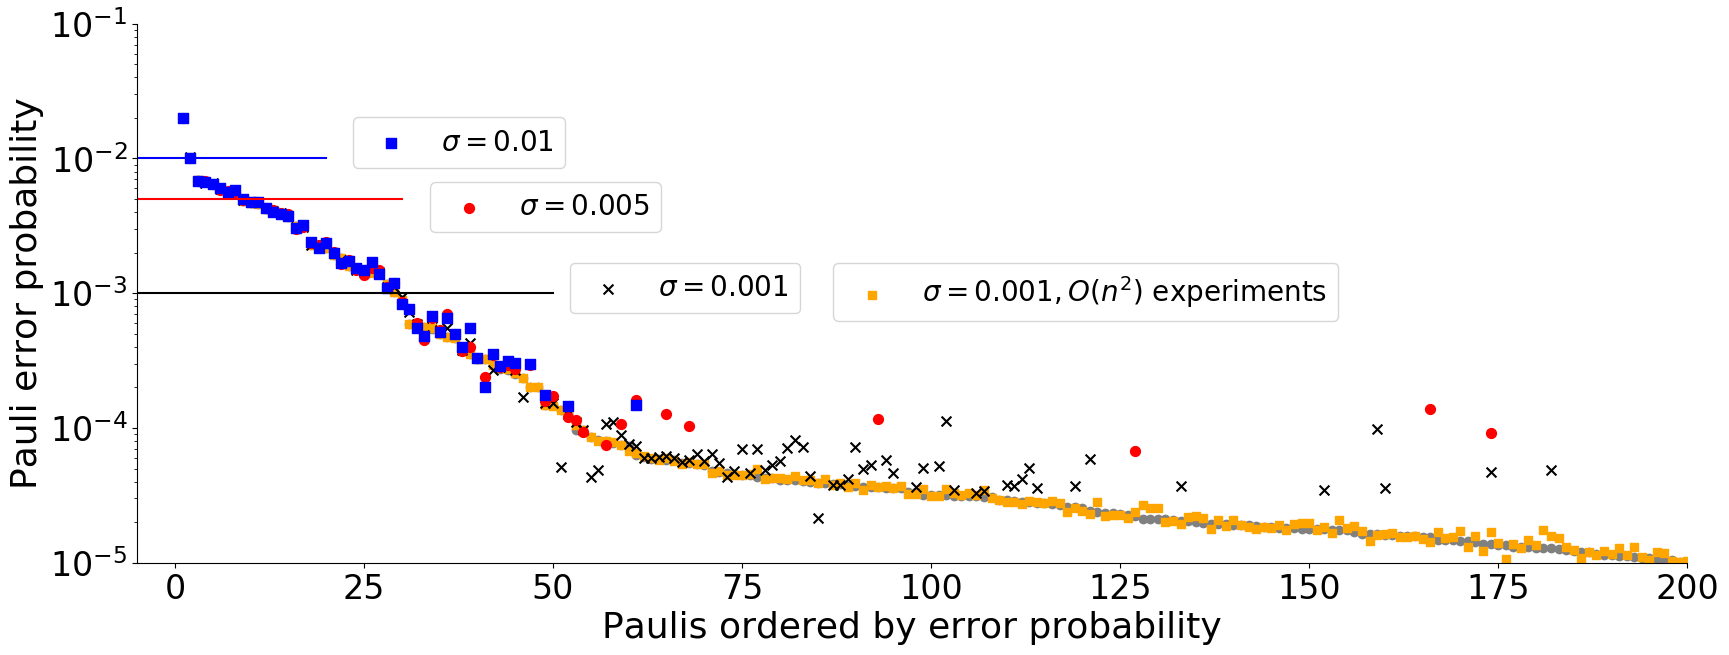

In [34]:
using PyPlot
fig = figure("Slightly larger",figsize=(20,7))
pCutoff=200
Seaborn.scatter(1:pCutoff,vec([x[2] for x in sfe[1:pCutoff]]),color="gray")
p4 = Seaborn.scatter(1:pCutoff,reconstructed4N[[x[1] for x in sfe[1:pCutoff]]],marker="s",color="orange",s=40,label=L"\sigma=0.01")


p1 = Seaborn.scatter(1:pCutoff,reconstructed3[[x[1] for x in sfe[1:pCutoff]]],marker="x",color="black",s=50,label=L"\sigma=0.001")
p2 = Seaborn.scatter(1:pCutoff,reconstructed2[[x[1] for x in sfe[1:pCutoff]]],marker="o",color="red",s=50,label=L"\sigma=0.005")
p3 = Seaborn.scatter(1:pCutoff,reconstructed1[[x[1] for x in sfe[1:pCutoff]]],marker="s",color="blue",s=50,label=L"\sigma=0.01")




Seaborn.plot([-10,20],[0.01,0.01],color="blue")
Seaborn.plot([-10,30],[0.005,0.005],color="red")
Seaborn.plot([-10,50],[0.001,0.001],color="black")




sb.despine()
yscale("log")
ylim([0.00001,0.1])
xlim([-5,200])
yticks(fontsize="24")
xticks(fontsize="24")
    #sb.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 108})
ylabel("Pauli error probability",fontsize="26")
xlabel("Paulis ordered by error probability",fontsize="26")
x1=legend(fontsize="26")
   ## ax= gca().add_axes([0.72, 0.72, 0.16, 0.16])
   # scatter(1:length(sfe),vec([x[2] for x in sfe]))
#    # scatter(1:length(ep),vec(ep),marker="x")
l1 = legend([p1], [L"\sigma=0.001"],bbox_to_anchor=(0.27, 0.48, 0.1, .102), loc=2,fontsize="20")
l4 = legend([p4], [L"\sigma=0.001, O(n^2) "*" experiments"],bbox_to_anchor=(0.44, 0.48, 0.1, .102), loc=2,fontsize="20")

l2 = legend([p2], [L"\sigma=0.005"],bbox_to_anchor=(0.18, 0.63, 0.1, .102), loc=2,fontsize="20") 
l3 = legend([p3], [L"\sigma=0.01"],bbox_to_anchor=(0.13, 0.75, 0.1, .102), loc=2,fontsize="20") 


gca().add_artist(l1) 
gca().add_artist(l2)
gca().add_artist(l4)
plt.show()

if savePics == true
    savefig("ReconstructionChartv2.pdf")
end

In [35]:
fe=filter(x->x[2]>0.0000001,collect(enumerate(p28)))
sfe = sort(fe,lt=(x,y)->x[2]>y[2])[2:end];




In [36]:
paramsN001 =  Dict("Cutoff"=>0.999995,"singletons"=>1e-11,
                "singletonIncrease"=>1e-11,
                "Zerosensitivity"=>1.1e-10,
                "ZerosensitivityDecrease"=>1e-12)


paramsN0001 = Dict("Cutoff"=>0.999995,"singletons"=>1e-12,
                "singletonIncrease"=>1e-12,
                "Zerosensitivity"=>1.1e-12,
                "ZerosensitivityDecrease"=>1e-14)

paramsN00001 = Dict("Cutoff"=>0.999995,"singletons"=>1e-13,
                "singletonIncrease"=>1e-13,
                "Zerosensitivity"=>1.1e-13,
                "ZerosensitivityDecrease"=>1e-15)



reconstructed4N_001 = reconstructWithNoise(0.001,paulisN2,mappings,ds,paramsN001,verbose=false,passTest=0.006);
reconstructed4N_0001 = reconstructWithNoise(0.0001,paulisN2,mappings,ds,paramsN0001,verbose=false,passTest=0.001);
reconstructed4N_00001 = reconstructWithNoise(0.00001,paulisN2,mappings,ds,paramsN00001,verbose=false,passTest=0.001);




print("N001   $(JSD(reconstructed4N_001,p28))\n")
print("N0001  $(JSD(reconstructed4N_0001,p28))\n")
print("N00001 $(JSD(reconstructed4N_00001,p28))\n")




N001   0.0027393334256127183
N0001  0.00044998345051038913
N00001 7.190309060779485e-5


In [37]:


params001 = Dict("Cutoff"=>0.999995,"singletons"=>1e-9,
                "singletonIncrease"=>2e-9,
                "Zerosensitivity"=>2.1e-9,
                "ZerosensitivityDecrease"=>1e-11)


params0001 = Dict("Cutoff"=>0.999995,"singletons"=>5e-10,
                "singletonIncrease"=>5e-10,
                "Zerosensitivity"=>2.1e-10,
                "ZerosensitivityDecrease"=>1e-12)


params00001 = Dict("Cutoff"=>0.999995,"singletons"=>1e-10,
                "singletonIncrease"=>1e-10,
                "Zerosensitivity"=>1.1e-10,
                "ZerosensitivityDecrease"=>1e-12)


reconstructed_001 = reconstructWithNoise(0.001,paulisAll,mappings,ds,params001,verbose=false,passTest=0.003);
reconstructed_0001 = reconstructWithNoise(0.0001,paulisAll,mappings,ds,params0001,verbose=false,passTest=0.0005);

print("001   $(JSD(reconstructed_001,p28))\n")
print("0001  $(JSD(reconstructed_0001,p28))\n")





001   0.0023557047314496406
0001  0.00156178211575038


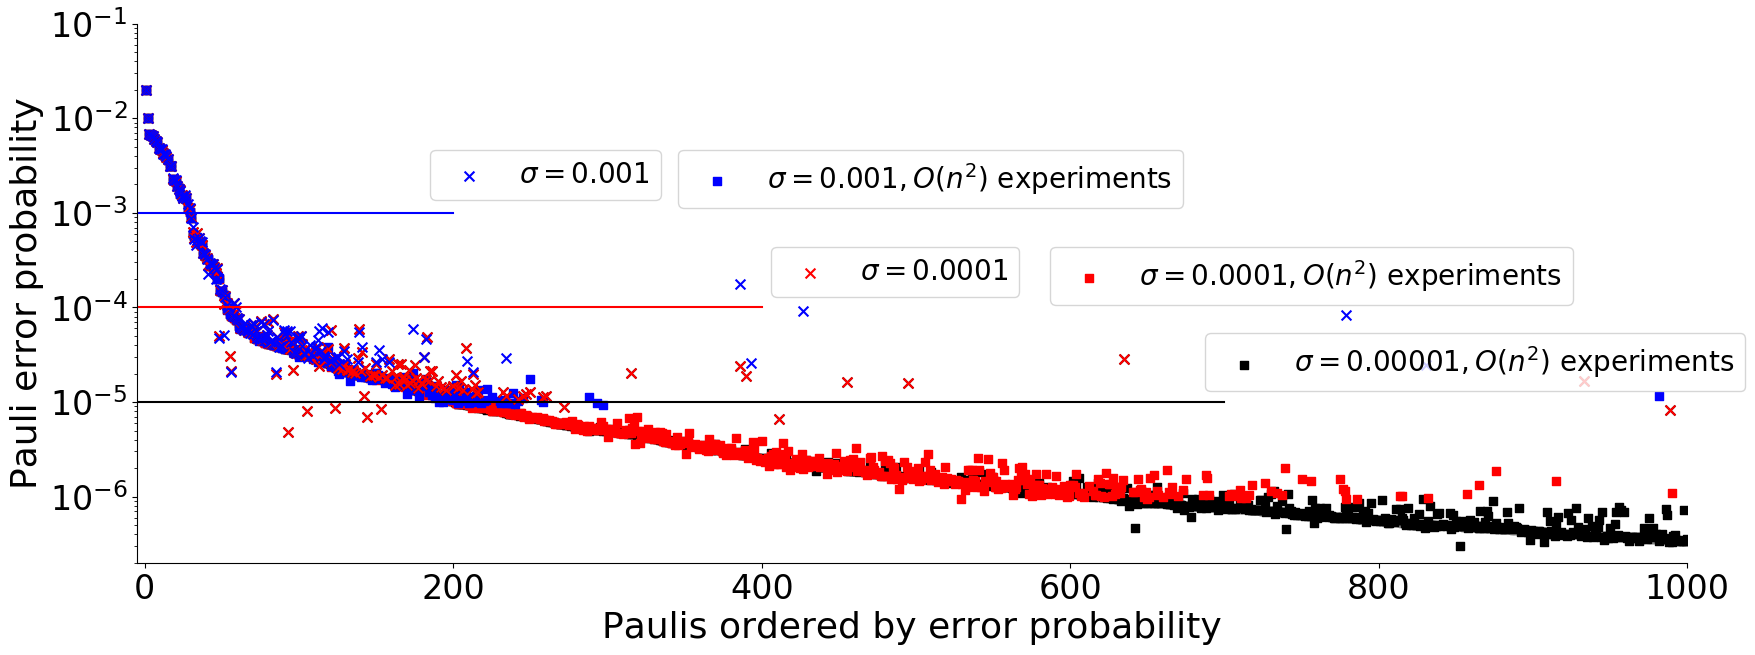

In [38]:
fig = figure("Slightly larger",figsize=(20,7))
pCutoff=1000
Seaborn.scatter(1:pCutoff,vec([x[2] for x in sfe[1:pCutoff]]),color="gray")

p4001 = Seaborn.scatter(1:pCutoff,reconstructed4N_00001[[x[1] for x in sfe[1:pCutoff]]],marker="s",color="black",s=40,label=L"\sigma=0.01")
p401 = Seaborn.scatter(1:pCutoff,reconstructed4N_0001[[x[1] for x in sfe[1:pCutoff]]],marker="s",color="red",s=40,label=L"\sigma=0.01")
p4 = Seaborn.scatter(1:pCutoff,reconstructed4N_001[[x[1] for x in sfe[1:pCutoff]]],marker="s",color="blue",s=40,label=L"\sigma=0.01")

p1001 = Seaborn.scatter(1:pCutoff,reconstructed_0001[[x[1] for x in sfe[1:pCutoff]]],marker="x",color="black",s=50,label=L"\sigma=0.001")
p101 = Seaborn.scatter(1:pCutoff,reconstructed_0001[[x[1] for x in sfe[1:pCutoff]]],marker="x",color="red",s=50,label=L"\sigma=0.001")
p1 = Seaborn.scatter(1:pCutoff,reconstructed_001[[x[1] for x in sfe[1:pCutoff]]],marker="x",color="blue",s=50,label=L"\sigma=0.001")






Seaborn.plot([-10,200],[0.001,0.001],color="blue")
Seaborn.plot([-10,400],[0.0001,0.0001],color="red")
Seaborn.plot([-10,700],[0.00001,0.00001],color="black")






sb.despine()
yscale("log")
ylim([0.0000002,0.1])
xlim([-5,pCutoff])
yticks(fontsize="24")
xticks(fontsize="24")
    #sb.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 108})
ylabel("Pauli error probability",fontsize="26")
xlabel("Paulis ordered by error probability",fontsize="26")
x1=legend(fontsize="26")
   ## ax= gca().add_axes([0.72, 0.72, 0.16, 0.16])
   # scatter(1:length(sfe),vec([x[2] for x in sfe]))
   # scatter(1:length(ep),vec(ep),marker="x")
l1 = legend([p1], [L"\sigma=0.001"],bbox_to_anchor=(0.18, 0.69, 0.1, .102), loc=2,fontsize="20")
l4 = legend([p4], [L"\sigma=0.001, O(n^2) "*" experiments"],bbox_to_anchor=(0.34, 0.69, 0.1, .102), loc=2,fontsize="20")
l2 = legend([p101], [L"\sigma=0.0001"],bbox_to_anchor=(0.4, 0.51, 0.1, .102), loc=2,fontsize="20")
l5 = legend([p401], [L"\sigma=0.0001, O(n^2) "*" experiments"],bbox_to_anchor=(0.58, 0.51, 0.1, .102), loc=2,fontsize="20")
l6 = legend([p4001], [L"\sigma=0.00001, O(n^2) "*" experiments"],bbox_to_anchor=(0.68, 0.35, 0.1, .102), loc=2,fontsize="20")





gca().add_artist(l1) 
gca().add_artist(l4)
gca().add_artist(l2)
gca().add_artist(l5)

plt.show()
if savePics == true
    savefig("HighDeltaPlot.pdf")
end

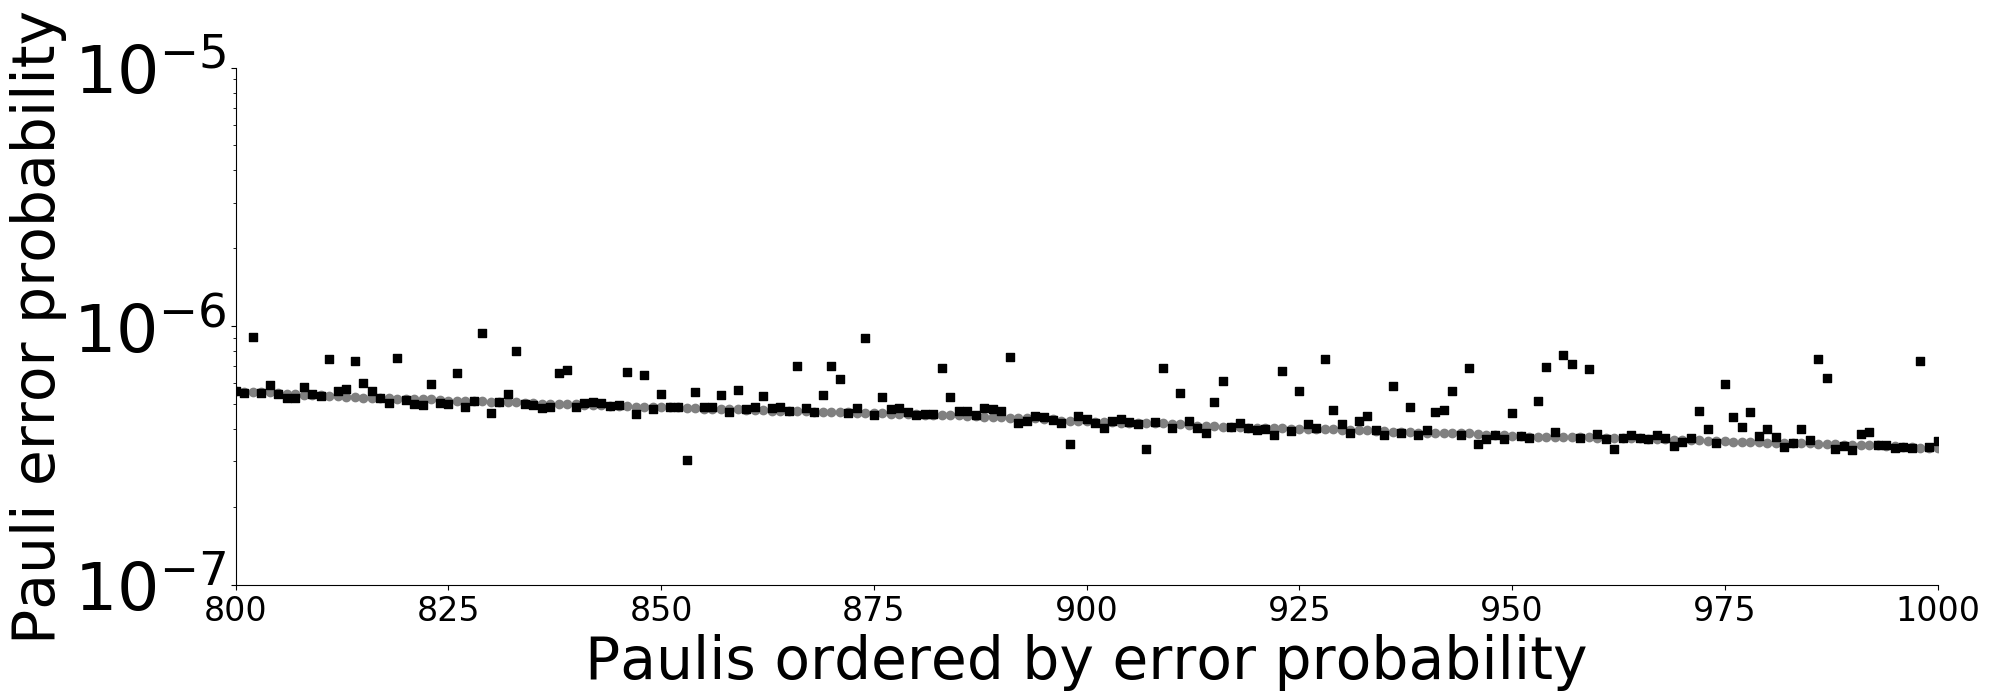

In [39]:
fig = figure("Slightly larger",figsize=(20,7))
pCutoff=1000
Seaborn.scatter(800:pCutoff,vec([x[2] for x in sfe[800:pCutoff]]),color="gray")

p4001 = Seaborn.scatter(800:pCutoff,reconstructed4N_00001[[x[1] for x in sfe[800:pCutoff]]],marker="s",color="black",s=40,label=L"\sigma=0.01")
# p401 = Seaborn.scatter(1:pCutoff,reconstructed4N_0001[[x[1] for x in sfe[1:pCutoff]]],marker="s",color="red",s=40,label=L"\sigma=0.01")
# p4 = Seaborn.scatter(1:pCutoff,reconstructed4N_001[[x[1] for x in sfe[1:pCutoff]]],marker="s",color="blue",s=40,label=L"\sigma=0.01")

# p1001 = Seaborn.scatter(1:pCutoff,reconstructed_0001[[x[1] for x in sfe[1:pCutoff]]],marker="x",color="black",s=50,label=L"\sigma=0.001")
# p101 = Seaborn.scatter(1:pCutoff,reconstructed_0001[[x[1] for x in sfe[1:pCutoff]]],marker="x",color="red",s=50,label=L"\sigma=0.001")
# p1 = Seaborn.scatter(1:pCutoff,reconstructed_001[[x[1] for x in sfe[1:pCutoff]]],marker="x",color="blue",s=50,label=L"\sigma=0.001")






# Seaborn.plot([-10,200],[0.001,0.001],color="blue")
# Seaborn.plot([-10,400],[0.0001,0.0001],color="red")
# Seaborn.plot([-10,700],[0.00001,0.00001],color="black")






sb.despine()
yscale("log")
ylim([1e-7,1e-5])
xlim([800,pCutoff])
yticks(fontsize="48")
xticks(fontsize="24")
    #sb.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 108})
ylabel("Pauli error probability",fontsize="42")
xlabel("Paulis ordered by error probability",fontsize="42")
# x1=legend(fontsize="26")
   ## ax= gca().add_axes([0.72, 0.72, 0.16, 0.16])
   # scatter(1:length(sfe),vec([x[2] for x in sfe]))
   # scatter(1:length(ep),vec(ep),marker="x")
# l1 = legend([p1], [L"\sigma=0.001"],bbox_to_anchor=(0.18, 0.69, 0.1, .102), loc=2,fontsize="20")
# l4 = legend([p4], [L"\sigma=0.001, O(n^2) "*" experiments"],bbox_to_anchor=(0.34, 0.69, 0.1, .102), loc=2,fontsize="20")
# l2 = legend([p101], [L"\sigma=0.0001"],bbox_to_anchor=(0.4, 0.51, 0.1, .102), loc=2,fontsize="20")
# l5 = legend([p401], [L"\sigma=0.0001, O(n^2) "*" experiments"],bbox_to_anchor=(0.58, 0.51, 0.1, .102), loc=2,fontsize="20")
# l6 = legend([p4001], [L"\sigma=0.00001, O(n^2) "*" experiments"],bbox_to_anchor=(0.68, 0.35, 0.1, .102), loc=2,fontsize="20")





# gca().add_artist(l1) 
# gca().add_artist(l4)
# gca().add_artist(l2)
# gca().add_artist(l5)
plt.tight_layout()
plt.show()
#if savePics == true
    savefig("HighDeltaInset2.pdf")
#end

## The next stage is to check our ability to recover specific Pauli errors that we are going to hide in the distribution

In [40]:
function genRandomHighishWeight()
    while true
        x = rand(0:1,28)
        if sum(x) > 12 
            return x
        end
    end
end
     

genRandomHighishWeight (generic function with 1 method)

In [41]:
reps = 200
combinedVals = []
@showprogress for (sd,ps) in [(0.001,params),(0.005,params1),(0.01,params2)]
  values = []
  @showprogress for _ = 1:reps
    myP = copy(p28)
    added = [foldl((x,y)->x<<1+y,genRandomHighishWeight())+1 for _ =1:4]
    for a in added
        myP[a] =rand(Normal(0.005,0.001))
    end
    myP[1] += 1-sum(myP)
    newOracle = ifwht_natural(myP)
    reconstructed = reconstructWithNoise(sd,paulisAll,mappings,ds,ps,oracleToUse=newOracle);
    for a in added
        push!(values,(myP[a] - reconstructed[a])/myP[a])
    end
  end
  push!(combinedVals,values)
end



Progress: 100%|█████████████████████████████████████████| Time: 2:18:00
Progress: 100%|█████████████████████████████████████████| Time: 1:15:41
Progress: 100%|█████████████████████████████████████████| Time: 1:17:20
Progress: 100%|█████████████████████████████████████████| Time: 4:51:02


In [42]:
open("localMuBsRecovery.csv", "w") do f
    write(f,"RelError,σ\n")
    for i = 1:reps*4
        write(f, "$(combinedVals[1][i]),  0.001\n")
        write(f, "$(combinedVals[2][i]), 0.005\n")
        write(f, "$(combinedVals[3][i]),  0.01\n")
    end
end



In [43]:
using Pandas 
rf = read_csv("localMuBsRecovery.csv"); 

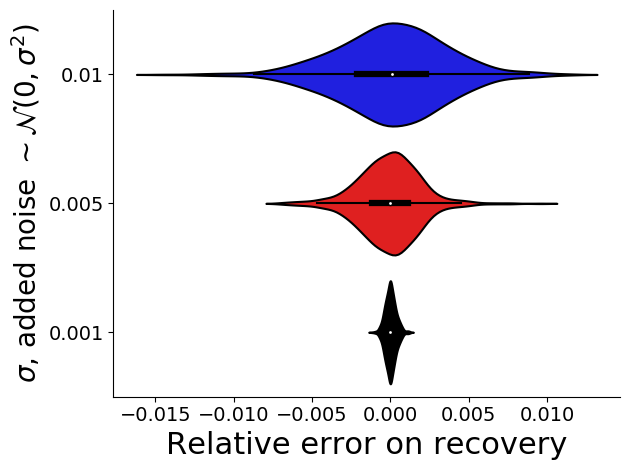

In [44]:
using PyCall
sb=pyimport("seaborn")
my_pal = Dict(0.01=> "b", 0.005=> "r", 0.001=>"k")


ax = violinplot(y="σ",x="RelError",data=rf,order=[0.01,0.005,0.001],scale="count",orient="h",palette=my_pal)
#ax = swarmplot(y="σ",x="RelError",data=rf,order=[0.01,0.005,0.001],
#                    color="white", edgecolor="gray",size=3,orient="h")
xlabel("Relative error on recovery",fontsize=22)
ylabel(L"$σ$, added noise $\sim\mathcal{N}(0,\sigma^2)$",fontsize=20)
sb.despine()
ax.tick_params(labelsize=14)
plt.tight_layout()
if savePics
    savefig("ViolinPlotRelError.pdf")
end

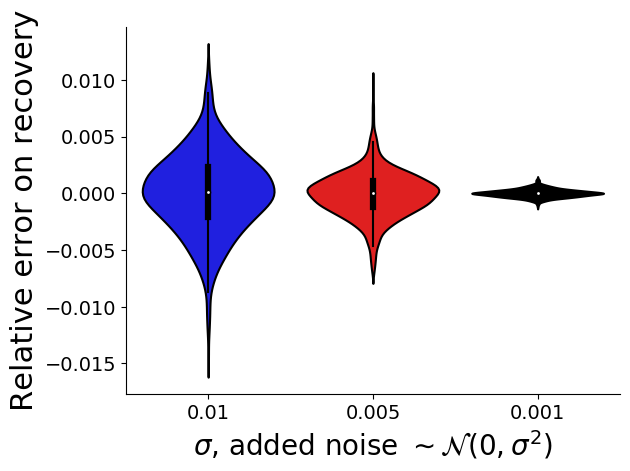

In [45]:
using PyCall
sb=pyimport("seaborn")
my_pal = Dict(0.01=> "b", 0.005=> "r", 0.001=>"k")


ax = violinplot(x="σ",y="RelError",data=rf,order=[0.01,0.005,0.001],scale="count",palette=my_pal)
# ax = swarmplot(x="σ",y="RelError",data=rf,order=[0.01,0.005,0.001],
#                     color="white", edgecolor="gray",size=3)
ylabel("Relative error on recovery",fontsize=22)
xlabel(L"$σ$, added noise $\sim\mathcal{N}(0,\sigma^2)$",fontsize=20)
sb.despine()
ax.tick_params(labelsize=14)
plt.tight_layout()
if savePics
    savefig("ViolinPlotRelErrorV.pdf")
end